# Checking how audio looks like

In [1]:
import numpy as np
import os
import shutil
import librosa
import IPython
import IPython.display as ipd 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
import scipy
from keras import losses, models, optimizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.activations import relu, softmax
from keras.utils import Sequence, to_categorical
from keras.layers import (Conv1D, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization,
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate, Flatten, LeakyReLU)
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

Using TensorFlow backend.


In [3]:
train = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")
test = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")

In [4]:
x = train.loc[train.label == "Saxophone"]
x = x.fname.head(5)

for i in x:
    print(i)
    fname = "../../Datasets/freesound-audio-tagging/audio_train/" + i
    IPython.display.display(ipd.Audio(filename=fname))

001ca53d.wav


05b76c07.wav


05e4028a.wav


06789937.wav


06f60188.wav


In [5]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [6]:
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


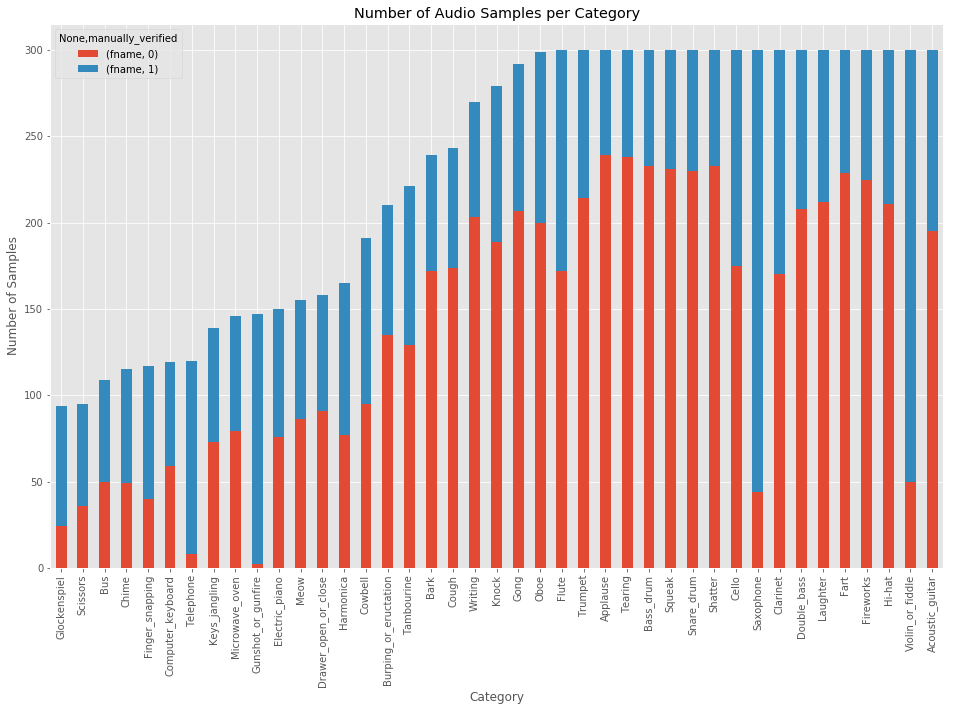

In [7]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [8]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


In [9]:
# CONSTS
DURATION = 4
SAMPLE_RATE = 44100
SHAPE = SAMPLE_RATE*DURATION
TRAIN_DATA_PATH = "../../Datasets/freesound-audio-tagging/audio_train/"

Total samples (frames) =  (231084,)
[ 0.0000000e+00 -2.1362305e-04 -5.7983398e-04 ... -9.1552734e-05
  0.0000000e+00 -3.0517578e-05]
<class 'numpy.ndarray'>


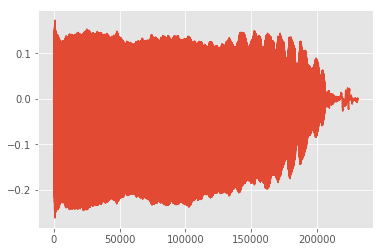

In [10]:
data, _ = librosa.core.load(fname, sr=SAMPLE_RATE, res_type='kaiser_fast')
print("Total samples (frames) = ", data.shape)
print(data)
print(type(data))
plt.plot(data, '-', )
plt.show()

Shape:  (40, 173)


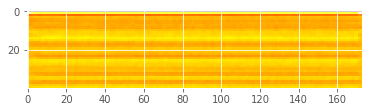

In [11]:
data = data[:2*44100]
mfcc = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=40)
print("Shape: ", mfcc.shape)
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

# Using GANs for new sounds

In [52]:
# Discriminator
def discriminator():
    model = Sequential()
    model.add(Dense(1024, input_shape=(SHAPE,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1, activation='tanh'))
    model.summary()
    return model

In [53]:
# Generator
def generator():
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(SHAPE, activation='tanh'))   
    return model

In [54]:
def stacked_G_D(G, D, optimizer):
    G.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    D.trainable = False 
    D.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    model = Sequential()
    model.add(G)
    model.add(D)
    return model

In [55]:
class AudioGAN:
    def __init__(self):
        self.OPTIMIZER = Adam(lr = 0.0002, decay = 8e-9)
        noise_gen = np.random.normal(0,1,(100,))
        # Generate Models
        self.G = generator()
        self.D = discriminator()
        self.stacked_G_D = stacked_G_D(self.G, self.D, self.OPTIMIZER)
        # Compile Models
        self.G.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER)
        self.D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
        self.stacked_G_D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER)
        
    def train(self, X_train, epochs = 200, batch = 64, save_interval = 20, label = "Saxophone"):
        train_data = X_train.loc[train.label == label]
        for cnt in range(epochs):
            # train discriminator
            halfBatch = int(batch/2)
            random_index = np.random.randint(0, len(train_data) - halfBatch)
            legit_audios = train_data[random_index : int(random_index + halfBatch)]
            legit_audios = self.data_generation(train_list = legit_audios, input_length = SHAPE).reshape(halfBatch, SHAPE)
            gen_noise = np.random.normal(0, 1, (halfBatch,100))
            syntetic_audios = self.G.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_audios, syntetic_audios))
            y_combined_batch = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            # train generator
            noise = np.random.normal(0, 1, (batch,100))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)
            if cnt % save_interval == 0 : 
                print ("epoch: %d" % (cnt)) 
                print ("Discriminator_loss: %f, Generator_loss: %f" % (d_loss[0], g_loss))
                show_audios(G = self.G, step = cnt)
                
    def data_generation(self, train_list, input_length):
        cur_batch_size = len(train_list)
        train_fname_list = train_list.fname
        X = np.empty((cur_batch_size, input_length))
        for i, train_fname in enumerate(train_fname_list):
            file_path = TRAIN_DATA_PATH + train_fname
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            X[i,] = data
        return X

In [56]:
def show_audios(G, samples = 4, step=0):
    noise = np.random.normal(0, 1, (samples,100))
    audios = G.predict(noise)
    for i, audio in enumerate(audios):
        print("Audio Gen %d" % i)
        IPython.display.display(ipd.Audio(data=audio, rate=SAMPLE_RATE))

In [ ]:
myGan = AudioGAN()
myGan.train(train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 1024)              180634624 
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_49 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 512)               2048      
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
__________

Audio Gen 1


Audio Gen 2


Audio Gen 3


In [104]:
gen_noise = np.random.normal(0, 1, (1,100))
gen_test = myGan.G.predict(gen_noise).flatten()
IPython.display.display(ipd.Audio(data=gen_test, rate=SAMPLE_RATE))

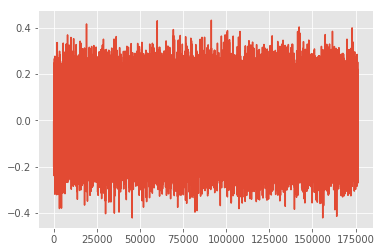

In [107]:
plt.plot(gen_test, '-', )
plt.show()